## 1. 사용할 패키지 불러오기

In [1]:
import cv2
import tqdm
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from librosa.feature import melspectrogram
import librosa
import librosa.display


## 2. 데이터 불러오기

In [2]:
ok_files = os.listdir("data/OK")
ng_files = os.listdir("data/NG")

## 3. Experiment Setting

### (1) Train Test 분할

Class Imbalaance 문제를 최소화하기 위해서 아래와 같이 Train과 Test를 구성한다.  

- Train: OK = 900개  NG = 900개
- Test: OK = 100개  NG = 100개

In [3]:
np.random.seed(555)
train_ok_samples = np.random.choice(a=ok_files, size=900, replace=False)
train_ng_samples = np.random.choice(a=ng_files, size=900, replace=False)
test_ok_samples = np.random.choice(a=list(set(ok_files)- set(train_ok_samples)), size=100, replace=False)
test_ng_samples = np.random.choice(a=list(set(ng_files) - set(train_ng_samples)), size=100, replace=False)

train_files = [os.path.join("data/OK", fname) for fname in train_ok_samples] + [os.path.join("./data/NG", fname) for fname in train_ng_samples]
test_files = [os.path.join("data/OK", fname) for fname in test_ok_samples] + [os.path.join("./data/NG", fname) for fname in test_ng_samples]
train_y = np.array([0] * len(train_ok_samples) + [1] * len(train_ng_samples))
test_y = np.array([0] * len(test_ok_samples) + [1] * len(test_ng_samples))


### (2) Make Features

In [4]:
def mel_spectrogram(file_name):  
    signal, _ = librosa.load(file_name, 16000)
    spec=melspectrogram(y=signal, sr=16000, n_fft=1024,
                        hop_length=512, n_mels=128)
    spec= librosa.power_to_db(S=spec, ref=np.max)
    spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))
    spec = np.stack([np.mean(spec,1), np.min(spec,1), np.max(spec,1), np.std(spec,1)])
    return spec.reshape(-1)

In [5]:
train_feature = [mel_spectrogram(file_name) for file_name in train_files]
train_feature = np.vstack(train_feature)

test_feature = [mel_spectrogram(file_name) for file_name in test_files]
test_feature = np.vstack(test_feature)

/tmp/ipykernel_27638/7161428.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal, _ = librosa.load(file_name, 16000)
/tmp/ipykernel_27638/7161428.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal, _ = librosa.load(file_name, 16000)


In [6]:
print("Train Feature: {}".format(train_feature.shape))
print("Test Feature: {}".format(test_feature.shape))


Train Feature: (1800, 512)
Test Feature: (200, 512)


### (3) PCA

#### 머신러닝을 사용하기에는 Feature가 너무 많아서 PCA를 활용하여 차원축소 진행

In [7]:
all_features = np.vstack([train_feature, test_feature])
pca = PCA(n_components=50)
printcipalComponents = pca.fit_transform(all_features)
principalDf = pd.DataFrame(data=printcipalComponents)


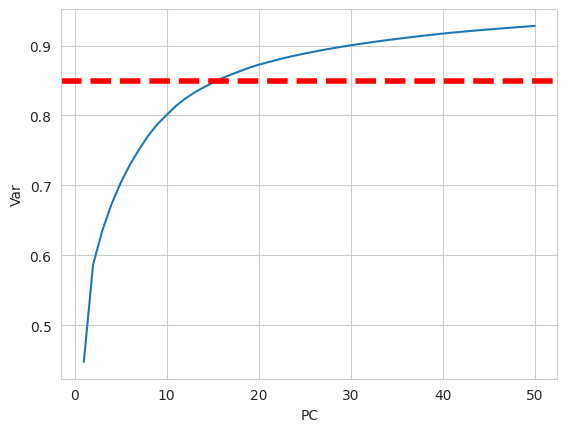

In [8]:
pca_var = pd.DataFrame({"PC": range(1, 51), "Var": np.cumsum(pca.explained_variance_ratio_)})
sns.set_style('whitegrid')
sns.lineplot(x='PC', y='Var', data=pca_var)
plt.axhline(0.85, 0, 50, color='red', linestyle='--', linewidth=4)

85% 설명력이 되는 16개의 PC를 활용하도록 한다.

In [10]:
pca = PCA(n_components=16)
printcipalComponents = pca.fit_transform(all_features)
principalDf = pd.DataFrame(data=printcipalComponents)
train_features = principalDf.iloc[:1800, :].reset_index(drop = True)
test_features = principalDf.iloc[1800:, :].reset_index(drop = True)


## 4. SVM

In [11]:
def find_best_hyperparameter(model, params, K):
    # Make K-folds dataset
    kfold = StratifiedKFold(n_splits = K, shuffle = True, random_state = 1004)
    
    # Make Grid Search
    grid = GridSearchCV(model, params, cv = kfold)

    # Conduct Hyperparameter Search
    grid.fit(train_features, train_y)
    best_params = grid.best_params_
    best_score = grid.best_score_

    # Print Result
    print("Best Hyper Parameter: {}".format(best_params))
    print("Best Score: {}".format(best_score))

    return best_params

In [12]:
svm_model = SVC(probability=True)
params = {'kernel': ['linear', 'rbf', 'poly'], 'C': [1, 10, 100]}
best_params = find_best_hyperparameter(svm_model, params, 5)

Best Hyper Parameter: {'C': 100, 'kernel': 'linear'}
Best Score: 0.745


## 5. Test Performance

In [13]:
svm_model = SVC()
svm_model.set_params(**best_params).fit(train_features, train_y)

SVC(C=100, kernel='linear')

In [14]:
true_y_list = test_y
predicted_list = svm_model.predict(test_features)

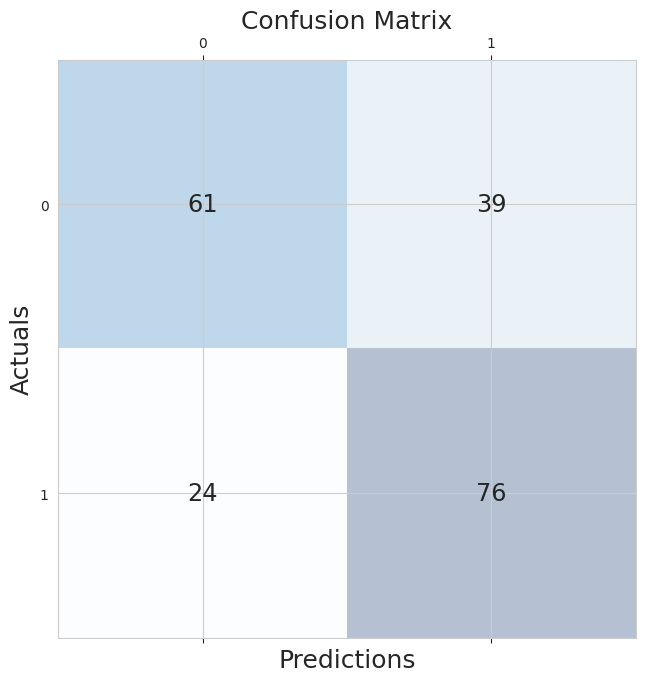

In [15]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [16]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.685
Test Precision: 0.6608695652173913
Test Recall: 0.76
Test F1 Score: 0.7069767441860464
